In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from avalanche.benchmarks import SplitMNIST
from avalanche.models import SimpleMLP
from avalanche.training import EWC
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.logging import InteractiveLogger
import os
import pickle

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SplitMNIST 数据集
benchmark = SplitMNIST(n_experiences=5, return_task_id=False)

# 模型、优化器、损失函数
model = SimpleMLP(num_classes=10)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 日志器和评估器
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(stream=True),
    loggers=[interactive_logger]
)

strategy = EWC(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    ewc_lambda=0.4,
    train_epochs=1,
    device=device,
    evaluator=eval_plugin
)

# 📌 用于记录每个任务的准确率
task_accuracies = []

# 开始训练每个 experience
for experience in benchmark.train_stream:
    print(f"\n--- Training on experience {experience.current_experience} ---")
    strategy.train(experience)

    print("--- Evaluating on test stream ---")
    results = strategy.eval(benchmark.test_stream)

    # 提取并记录 accuracy
    task_accuracies.append(results)

# Define the file path
file_path = "/home/yangz2/code/quantum_cl/results/list/try.pkl"

# Create directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)  # <-- Add this line   

# 存储到文件
with open(file_path, "wb") as f:
    pickle.dump([task_accuracies], f)  
    
with open(file_path, "rb") as f:
    task_accuracies = pickle.load(f) 
# ✅ 绘图
# 遍历 results 提取 Loss_Exp 数据

x= []  # x 轴数据
num_experiences = 5  # SplitMNIST 有 5 个 experience，但每个 experience 对应 4 次 eval
count = 1  # 用于标记经验编号
loss_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Loss_Exp/eval_phase/test_stream/Task000/Exp00{exp_id}"
        loss = result.get(key, None)
        if loss is not None:  # 确保键存在
            loss_values.append(loss)
            x.append(count)  # x 轴连续编号
            count += 1

# 遍历 results 提取 Top1_Acc_Exp 数据
top1_acc_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{exp_id}"
        top1_acc = result.get(key, None)
        if top1_acc is not None:  # 确保键存在
            top1_acc_values.append(top1_acc)

# 遍历 resutls 中的 Forgetting 数据, 但是是每个stream的Forgetting
forgetting_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, num_experiences):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"StreamForgetting/eval_phase/test_stream"
        forgetting = result.get(key, None)
        if forgetting is not None:  # 确保键存在
            forgetting_values.append(forgetting)


# 绘制图形
plt.figure(figsize=(20, 6))
plt.plot(x, loss_values, marker='o', linestyle='-', color='b', label='Loss_Exp')
plt.title("Loss over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Loss Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend("splitminist_EWC_qbit8_qdepth10_loss")
plt.tight_layout()
plt.savefig("/home/yangz2/code/quantum_cl/results/figs/loss_try.png")

plt.figure(figsize=(20, 6))
plt.plot(x, top1_acc_values, marker='o', linestyle='-', color='r', label='Top1_Acc_Exp')
plt.title("Top1_Acc over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Top1_Acc Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend("splitminist_EWC_qbit8_qdepth10_acc")
plt.tight_layout()
plt.savefig("/home/yangz2/code/quantum_cl/results/figs/acc_try.png")

plt.figure(figsize=(20, 6))
plt.plot(range(1, len(forgetting_values) + 1), forgetting_values, marker='o', linestyle='-', color='g', label='StreamForgetting')
plt.title("StreamForgetting over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("StreamForgetting Value")
plt.xticks(range(1, len(forgetting_values) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend("splitminist_EWC_qbit8_qdepth10_forget")
plt.tight_layout()
plt.savefig("/home/yangz2/code/quantum_cl/results/figs/forget_try.png")

KeyboardInterrupt: 

In [15]:
with open(file_path, "rb") as f:
    task_accuracies = pickle.load(f) 
    
print(task_accuracies)

[[{'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.2001}, {'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.1991}, {'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.2159}, {'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.1959}, {'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.1889}]]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane.qnn import TorchLayer
from torchvision import transforms

from avalanche.benchmarks.classic import SplitMNIST
from avalanche.training import EWC
from avalanche.training.plugins import EvaluationPlugin,SupervisedPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger
import pickle
import os

2025-06-11 10:25:57.973440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 10:25:58.011922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 10:25:58.023776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-11 10:25:59.966058: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yangz2/anaconda3/envs/quan_cl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

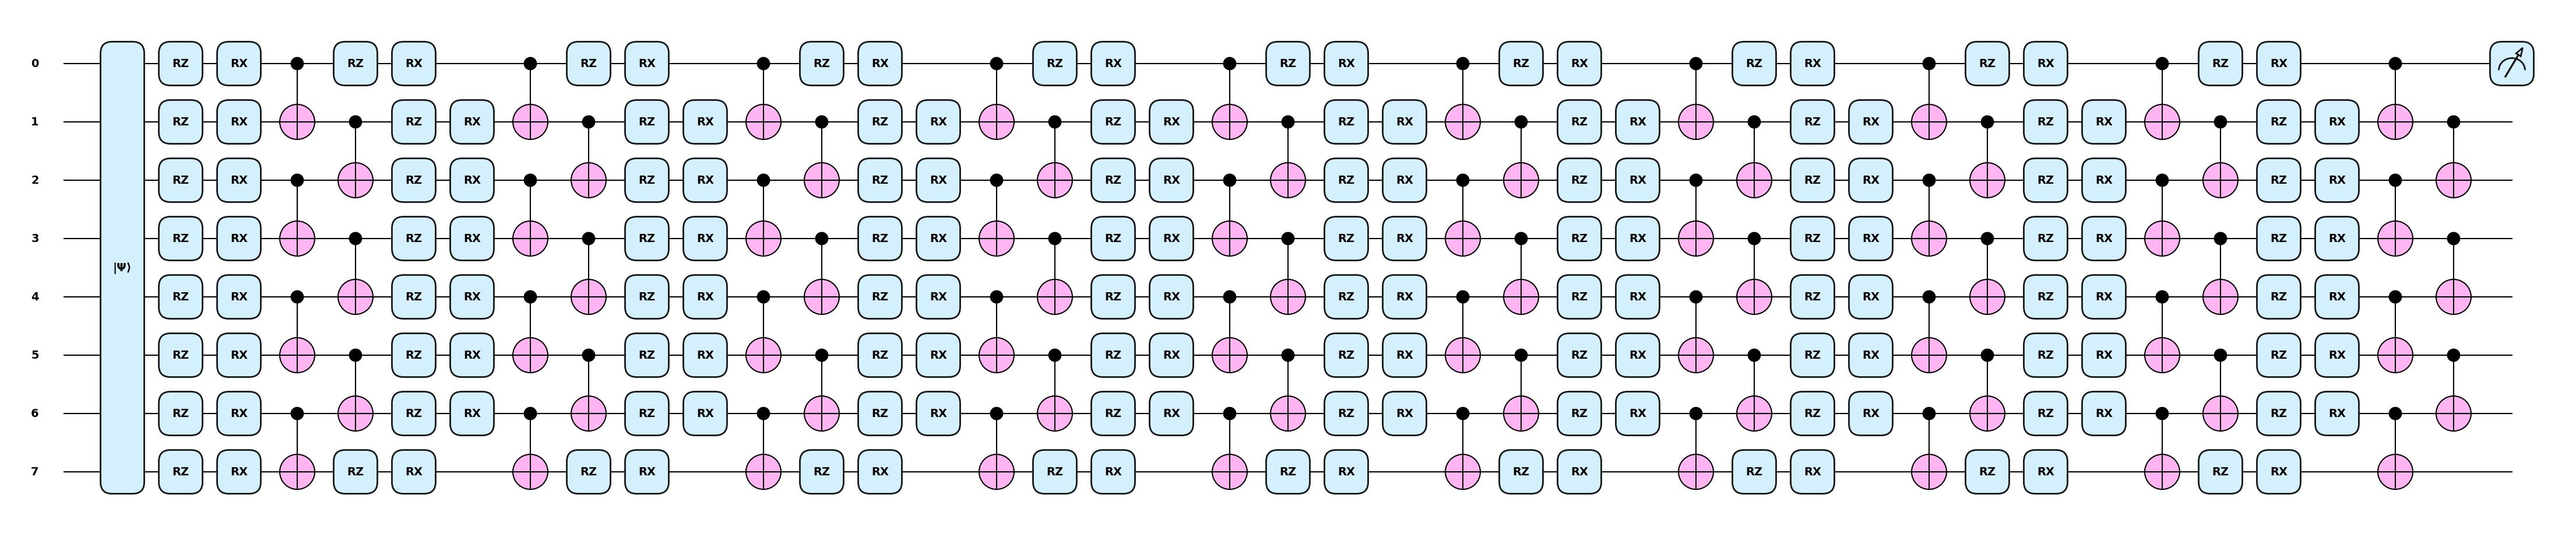

In [2]:
# -----------------------------
# 1. Quantum Circuit Definition (Multi-layer)
# -----------------------------
n_qubits = 8
input_dim = 784  # 28 x 28 MNIST
n_layers = 10  # ✅ Now actually used
dev = qml.device("lightning.qubit", wires=n_qubits)

def quantum_circuit(inputs, weights):
    # 💡 Clamp 限制输入范围，防止极端归一化后振幅很小或很大
    inputs = qml.math.clip(inputs, -1.0, 1.0)
    # 1. Amplitude embedding（必须 L2 归一化）
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    # weights: [n_layers, n_qubits, 2]
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RZ(weights[layer, i, 0], wires=i)
            qml.RX(weights[layer, i, 1], wires=i)

        # Entanglement layer (odd-even alternating)
        for i in range(0, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CNOT(wires=[i, i + 1])

    return qml.expval(qml.PauliZ(0))

qml.drawer.use_style("pennylane")
# 输入：8个量子比特
inputs = torch.randn(2 ** n_qubits)

# 权重：10 层，每层 8 比特，每比特两个参数（RZ, RX）
weights = torch.randn(n_layers, n_qubits, 2)

# 绘制电路
fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
plt.show()

# -----------------------------
# 2. TorchLayer + PyTorch Model
# -----------------------------
weight_shapes = {"weights": (n_layers, n_qubits, 2)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch")
qlayer = TorchLayer(qnode, weight_shapes)
with torch.no_grad():
    qlayer.weights.data = qlayer.weights.data * 0.1

class QuantumClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.q_layer = qlayer
        self.output = nn.Linear(1, 10)

    def forward(self, x):
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        # 添加epsilon并确保归一化维度正确
        x = F.normalize(x + 1e-8, p=2, dim=1)  # 注意dim=1（batch维度）
        x = self.q_layer(x)
        x = x.unsqueeze(1)  # 确保输出形状匹配
        x = self.output(x)
        return F.log_softmax(x, dim=1)


In [ ]:
# -----------------------------
# 3. Data Transform (Only 8 pixels used)
# -----------------------------
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.view(-1)),  # 展平为784
    # 修正：当原维度>256时截断，否则填充（原逻辑错误）
    transforms.Lambda(lambda x: x[:256] if x.shape[0] > 256 else F.pad(x, (0, 256 - x.shape[0]))),
    transforms.Lambda(lambda x: torch.clamp(x, -1.0, 1.0)),
    # 添加epsilon防止除零
    transforms.Lambda(lambda x: F.normalize(x + 1e-8, p=2, dim=0)) 
])

benchmark = SplitMNIST(n_experiences=5, return_task_id=False,
                       train_transform=transform, eval_transform=transform)

# -----------------------------
# 4. Avalanche EWC Strategy Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QuantumClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(experience=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=10, save_image=True,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger]
)

strategy = EWC(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    ewc_lambda=0.4,
    train_epochs=10,
    device=device,
    evaluator=eval_plugin
)


class GradientClipPlugin(SupervisedPlugin):
    def before_backward(self, strategy, **kwargs):
        torch.nn.utils.clip_grad_norm_(strategy.model.parameters(), max_norm=1.0)

strategy.plugins.append(GradientClipPlugin())

# -----------------------------
# 5. Training & Accuracy Recording
# -----------------------------
task_accuracies = []

for experience in benchmark.train_stream:
    print(f"\n--- Training on experience {experience.current_experience} ---")
    strategy.train(experience)

    print("--- Evaluating on test stream ---")
    results = strategy.eval(benchmark.test_stream)

    task_accuracies.append(results)
 




--- Training on experience 0 ---
-- >> Start of training phase << --
  0%|          | 56/12665 [00:07<20:38, 10.18it/s] 

KeyboardInterrupt: 

In [3]:
# Define the file path
file_path = "/home/yangz2/code/quantum_cl/results/list/try.pkl"

# Create directories if they don't exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)  # <-- Add this line   
   

In [ ]:
# 存储到文件
with open(file_path, "wb") as f:
    pickle.dump([task_accuracies], f)  

<class 'list'>
[{'Top1_Acc_MB/train_phase/train_stream/Task000': 1.0, 'Loss_MB/train_phase/train_stream/Task000': 0.00139639584813267, 'RunningTime_Epoch/train_phase/train_stream/Task000': 2.0967369156628783e-05, 'DiskUsage_MB/train_phase/train_stream/Task000': 225.916015625, 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.9807904802379941, 'Loss_Epoch/train_phase/train_stream/Task000': 0.054756135089746874, 'Time_Epoch/train_phase/train_stream/Task000': 1441.582385738846, 'DiskUsage_Epoch/train_phase/train_stream/Task000': 225.916015625, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9770642201834863, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.06530972789653615, 'CPUUsage_Exp/eval_phase/test_stream/Task000/Exp000': 704.775154061095, 'DiskUsage_Exp/eval_phase/test_stream/Task000/Exp000': 225.916015625, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': 0.0, 'Loss_Exp/eval_phase/test_stream/Task000/Exp001': 24.04033867221935, 'CPUUsage_Exp/eval_phase/test_strea

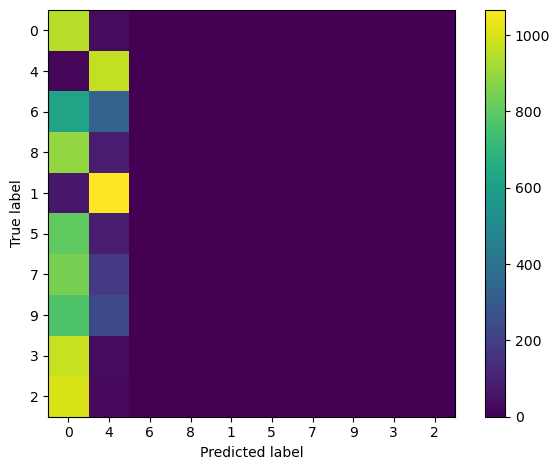

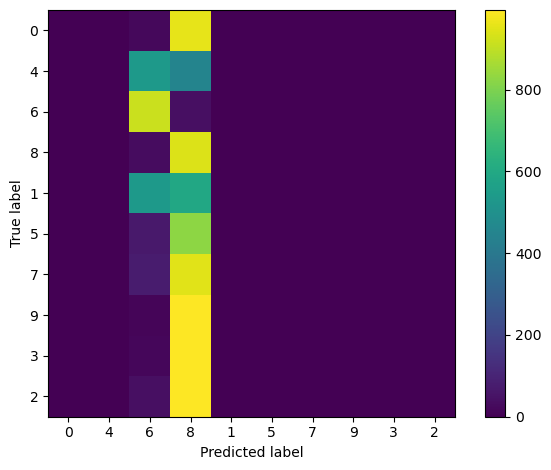

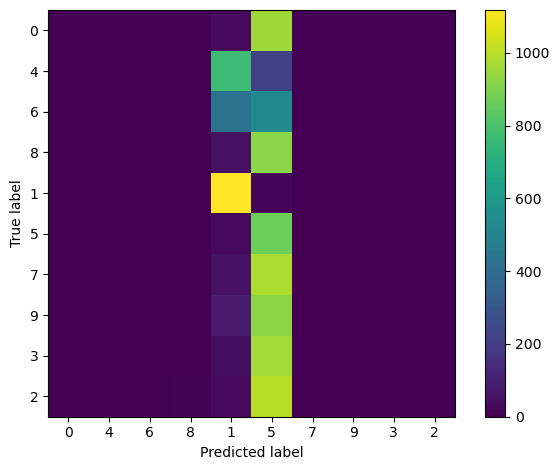

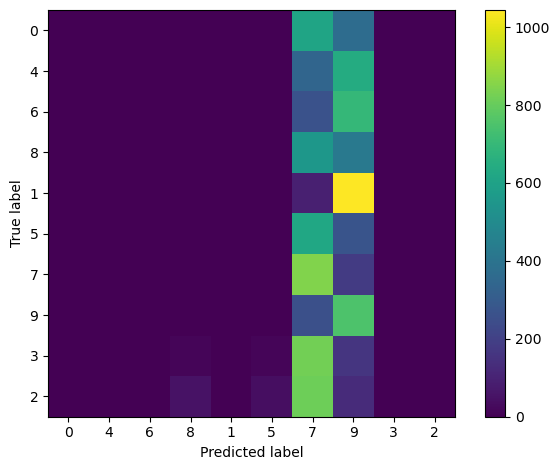

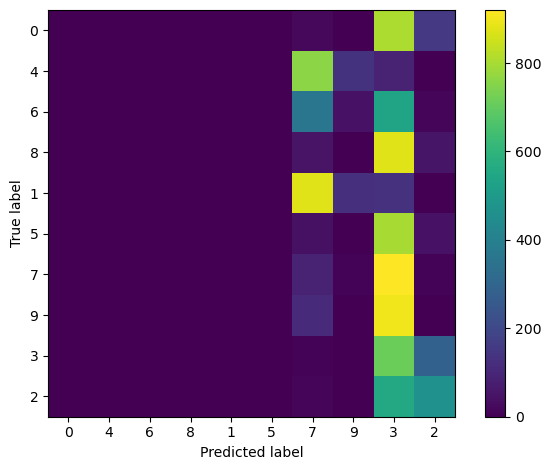

In [4]:
file_path = "/home/yangz2/code/quantum_cl/results/list/splitminist_EWC_qbit8_qdepth10.pkl"
with open(file_path, "rb") as f:
    results = pickle.load(f)  
    
print(type(results))
print(results)

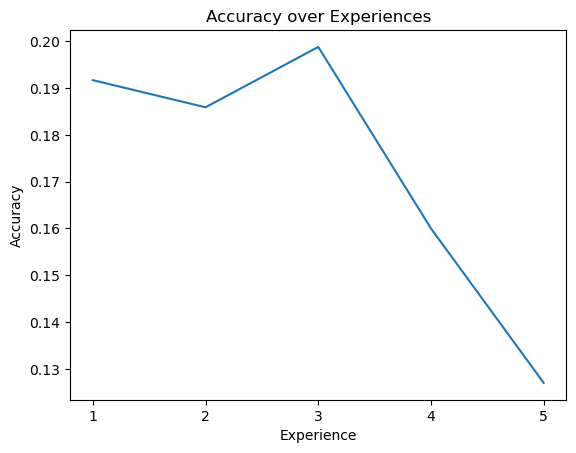

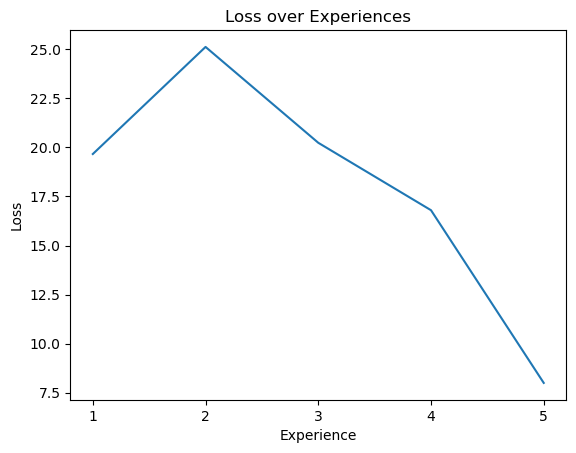

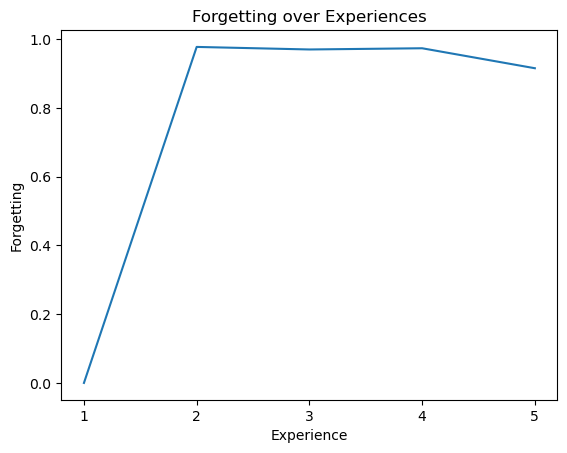

In [6]:
import matplotlib.pyplot as plt

# results = pickle.load(…)  # 已经加载好的 list of dict
save_dir = "/home/yangz2/code/quantum_cl/results/figs"

# 1) 准备横轴（experience 序号）
exp_idxs = list(range(1, len(results) + 1))

# 2) 从 results 中提取三条曲线
accuracies  = [r['Top1_Acc_Stream/eval_phase/test_stream/Task000'] for r in results]
losses      = [r['Loss_Stream/eval_phase/test_stream/Task000']      for r in results]
forgettings = [r['StreamForgetting/eval_phase/test_stream']         for r in results]

# 3) 画 Accuracy
plt.figure()
plt.plot(exp_idxs, accuracies)
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.title('Accuracy over Experiences')
plt.xticks(exp_idxs)
plt.savefig(os.path.join(save_dir, "splitmnist_EWC_qbit8_qdepth4_tepoch40_acc.png"))

# 4) 画 Loss
plt.figure()
plt.plot(exp_idxs, losses)
plt.xlabel('Experience')
plt.ylabel('Loss')
plt.title('Loss over Experiences')
plt.xticks(exp_idxs)
plt.savefig(os.path.join(save_dir, "splitmnist_EWC_qbit8_qdepth4_tepoch40_loss.png"))

# 5) 画 Forgetting
plt.figure()
plt.plot(exp_idxs, forgettings)
plt.xlabel('Experience')
plt.ylabel('Forgetting')
plt.title('Forgetting over Experiences')
plt.xticks(exp_idxs)
plt.savefig(os.path.join(save_dir, "splitmnist_EWC_qbit8_qdepth4_tepoch40_forget.png"))

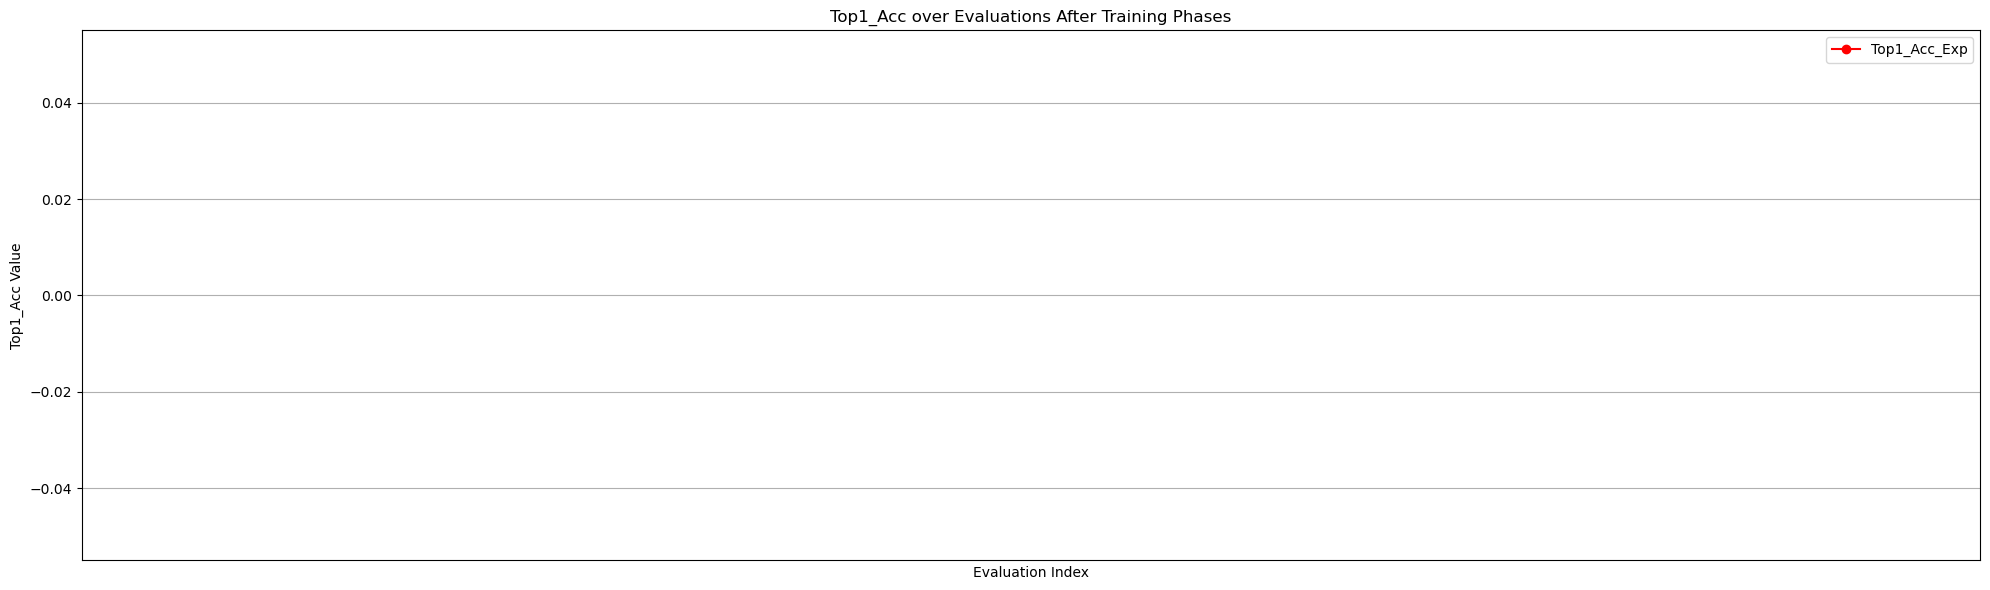

In [11]:
key = "Top1_Acc_Stream/eval_phase/test_stream/Task000"
top1_acc_values = [res.get(key, None) for res in results if key in res]

x = list(range(1, len(top1_acc_values) + 1))

plt.figure(figsize=(20, 6))
plt.plot(x, top1_acc_values, marker='o', linestyle='-', color='r', label='Top1_Acc_Exp')
plt.title("Top1_Acc over Evaluations After Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Top1_Acc Value")
plt.xticks(x)  # 设置 x 轴刻度
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "splitminist_EWC_qbit8_qdepth10_acc.png"))
plt.show()